# Clustering

[reference](https://scikit-learn.org/stable/modules/clustering.html)

In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from scipy.ndimage.filters import gaussian_filter

from skimage.data import coins
from skimage.transform import rescale

from sklearn import feature_extraction
from sklearn.cluster import (KMeans, MiniBatchKMeans, AffinityPropagation, MeanShift, estimate_bandwidth,
                             spectral_clustering)
from sklearn.datasets import make_blobs, load_digits
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

## demonstration of k-means assumptions

[reference](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html)

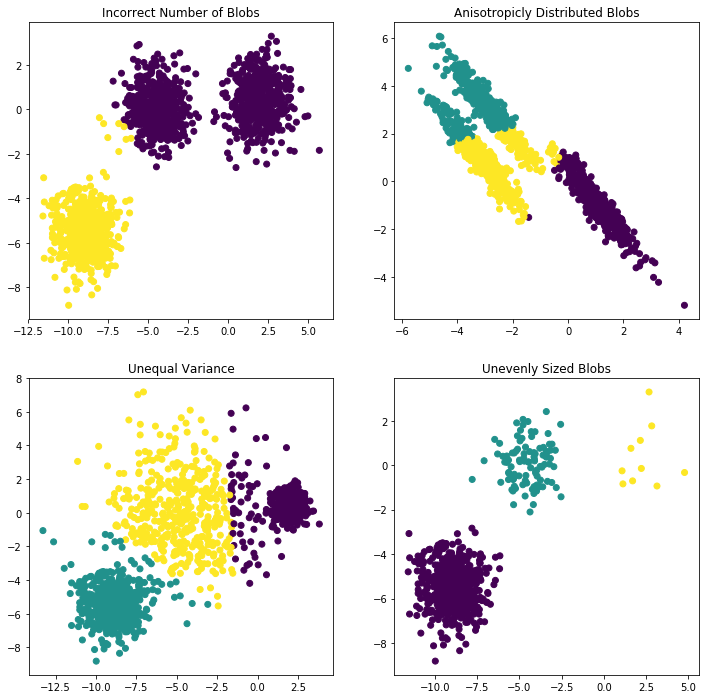

In [2]:
n_samples = 1500
X, y = make_blobs(n_samples=n_samples, random_state=170)
plt.figure(figsize=(12,12))

y_pred = KMeans(n_clusters=2, random_state=170).fit_predict(X)
plt.subplot(221)
plt.scatter(X[:,0], X[:,1], c=y_pred)
plt.title('Incorrect Number of Blobs')

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=170).fit_predict(X_aniso)
plt.subplot(222)
plt.scatter(X_aniso[:,0], X_aniso[:,1], c=y_pred)
plt.title('Anisotropicly Distributed Blobs')

X_varied, y_varied = make_blobs(n_samples=n_samples, cluster_std=[1.0,2.5,0.5], random_state=170)
y_pred = KMeans(n_clusters=3, random_state=170).fit_predict(X_varied)
plt.subplot(223)
plt.scatter(X_varied[:,0], X_varied[:,1], c=y_pred)
plt.title('Unequal Variance')

X_filtered = np.vstack((X[y==0][:500], X[y==1][:100], X[y==2][:10]))
y_pred = KMeans(n_clusters=3, random_state=170).fit_predict(X_filtered)
plt.subplot(224)
plt.scatter(X_filtered[:,0], X_filtered[:,1], c=y_pred)
_ = plt.title('Unevenly Sized Blobs')

## A demo of K-Means clustering on the handwritten digits data

[reference](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)

init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.33s	69432	0.602	0.650	0.625	0.465	0.621	0.146
random   	0.29s	69694	0.669	0.710	0.689	0.553	0.686	0.147
PCA-based	0.04s	70804	0.671	0.698	0.684	0.561	0.681	0.118


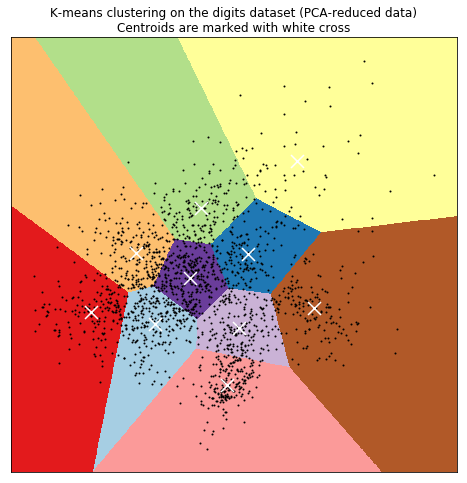

In [3]:
np.random.seed(42)

digits = load_digits()
data = scale(digits.data) #(np,float,(1797,64))
labels = digits.target #(np,int,(1797,)) 0~9

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))

def bench_k_means(estimator, name, data):
    t0 = time.time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time.time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_, average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_, metric='euclidean', sample_size=300)))

print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10), name="k-means++", data=data)
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10), name="random", data=data)
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1), name="PCA-based", data=data)


# Visualize the results on PCA-reduced data
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Comparison of the K-Means and MiniBatchKMeans clustering algorithms

[reference](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

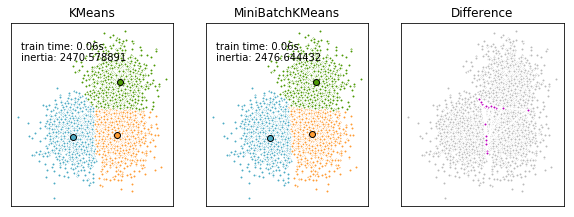

In [4]:
np.random.seed(0)
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size, n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)
order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' % (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w', markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w', markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

## Demo of affinity propagation clustering algorithm

[reference](https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html)

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


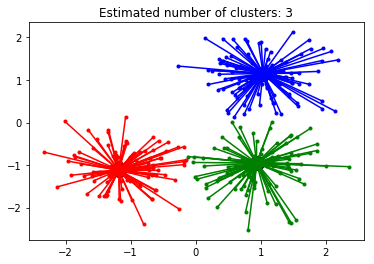

In [5]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5, random_state=0)

af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"%metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"%metrics.adjusted_mutual_info_score(labels_true, labels, average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"%metrics.silhouette_score(X, labels, metric='sqeuclidean'))

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## A demo of the mean-shift clustering algorithm

[reference](https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html)

number of estimated clusters : 3


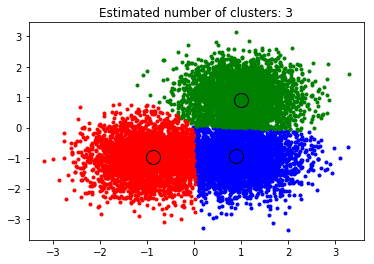

In [6]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)


colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Spectral clustering for image segmentation

[reference](https://scikit-learn.org/stable/auto_examples/cluster/plot_segmentation_toy.html)

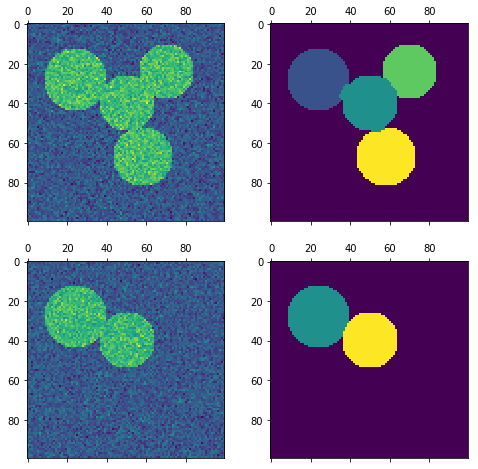

In [8]:
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = feature_extraction.image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

fig = plt.figure(figsize=(8,8))
(ax0,ax1),(ax2,ax3) = fig.subplots(2,2)
ax0.matshow(img)
ax1.matshow(label_im)

# #############################################################################
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)
graph = feature_extraction.image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

ax2.matshow(img)
ax3.matshow(label_im)
plt.show()

## Segmenting the picture of greek coins in regions

[reference](https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_segmentation.html)

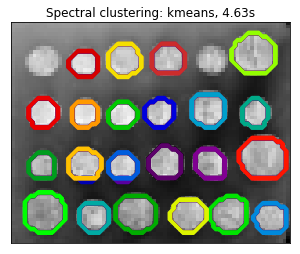

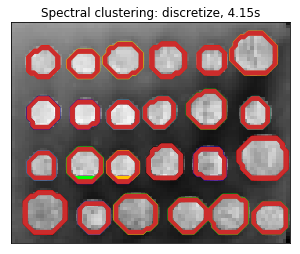

In [10]:
orig_coins = coins()
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", multichannel=False, anti_aliasing=False)

graph = feature_extraction.image.img_to_graph(rescaled_coins)
graph.data = np.exp(-10 * graph.data / graph.data.std()) + 1e-6
N_REGIONS = 25

for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=42)
    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels==l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0)))
plt.show()